# Solution for qualification problem number 2 for ICM workshop in Jan 2017, by Grzegorz Uriasz

In this solution I will show all of my approaches for solving this problem. To determine what was be the most accurate architecture each model was build from scratch and then the training process consisted of the same number of epochs and the same optimizer algorithm to ensure that the diffrences are not caused by longer training times or different training algorithms.

In [1]:
#Importing and preconfiguration of neccesary modules
%matplotlib inline

import pycuda
import theano

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, Convolution2D, MaxPooling2D, Input, merge, AveragePooling2D, UpSampling2D
from keras.optimizers import SGD

from keras.utils import np_utils
from scipy import io
from scipy.misc import imresize

import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
import pandas as pd

import os
import sys
import time

#for displaying keras model visualizations
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

from keras_ascii_sequential import sequential_model_to_ascii_printout

Using gpu device 0: GeForce GTX 550 Ti (CNMeM is enabled with initial size: 50.0% of memory, cuDNN not available)
Using Theano backend.


In [2]:
#loading notMNIST datasheet from http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html
if(not os.path.isfile("./notMNIST_small.mat")):
    #get the dataset
    sys.stdout.write(b"Fetching the dataset from the internet")
    import requests
    s = requests.Session()
    while(True):
        r = s.get("http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat", stream="True")
        if(r.status_code == 200):
            f = open("./notMNIST_small.mat", 'wb')
            for chunk in r.iter_content(chunk_size=512 * 1024): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
                    sys.stdout.write(b".")
                    sys.stdout.flush()
            f.close()
            print("Done")
            break
        os.sleep(200) #do not dos the server :)
    del s #close sesion
    del requests
    
data = io.loadmat("./notMNIST_small.mat")

#preparation of the data
X = data['images']
y = data['labels']
resolution = 28
classes = 10

X = np.transpose(X, (2, 0, 1))

y = y.astype('int32')
X = X.astype('float32') / 255.

Y = np_utils.to_categorical(y,10)

Fetching the dataset from the internet..............................................................................................................................................................................................................................................................................................................Done


In [3]:
#Generation of the training and test set
#Let the seed for the RNG be the most random number in the world - https://xkcd.com/221/
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=4)

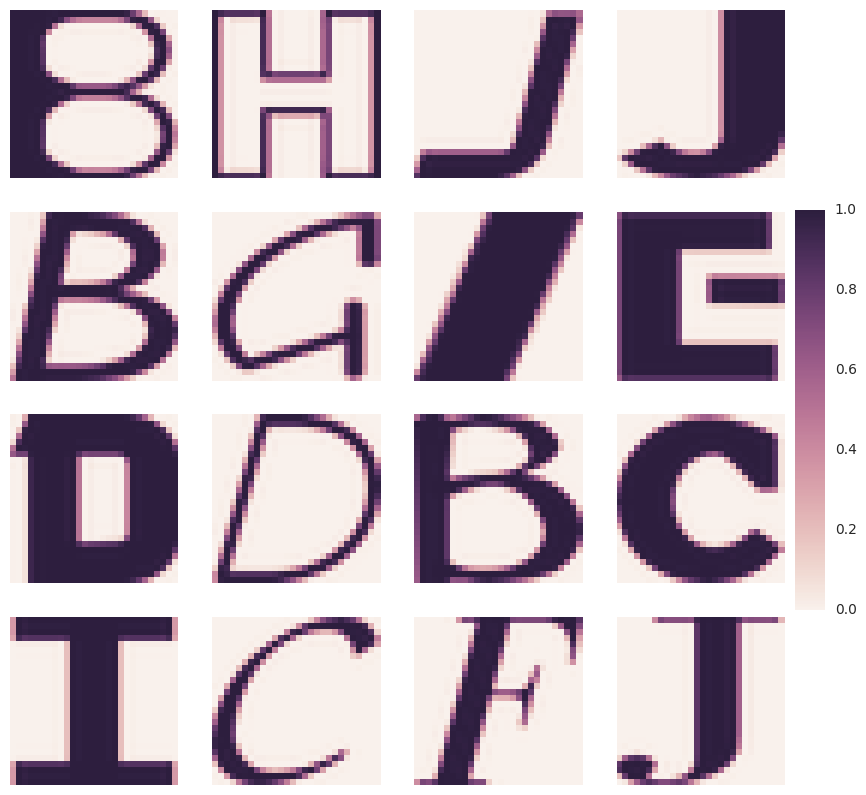

In [4]:
#Plot some of the test data
np.random.seed(4) #again the same seed
plt.rcParams['figure.figsize'] = (10,10)
fig, axn = plt.subplots(4, 4, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
X_test_len = len(X_test)
for i, ax in enumerate(axn.flat):
    sns.heatmap(X_test[np.random.randint(0, X_test_len)], ax=ax,
                cbar=i == 0,
                vmin=0, vmax=1,
                cbar_ax=None if i else cbar_ax,
               xticklabels=False, yticklabels=False)

### After the datasets are prepared I made a function to train and analyze the performance of a given model

In [5]:
nb_epoch = 10
#For other networks
optimizer = "adam"
batch_size = 32
#For squeezeNet
#optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#batch_size = 12 #training squeezeNet involves lots of GPU memory 
def TrainAndAnalyze(model=None, train_data=None, test_data=None, trained=False, save_filename=None):
    if not trained:
        #compile the model
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        #train the model using 10 epochs
        history = model.fit(train_data[0], train_data[1], nb_epoch=nb_epoch, batch_size=batch_size, validation_data=test_data)
        
        #plot loss over epoch on the training and testing data
        plt.rcParams['figure.figsize'] = (10,5)
        history.history['epoch'] = range(1,nb_epoch+1)
        fig, axn = plt.subplots(1, 2, sharex=True, sharey=True)
        sns.regplot('epoch', 'loss', data=pd.DataFrame(history.history), fit_reg=False, ax=axn.flat[0])
        sns.regplot('epoch', 'val_loss', data=pd.DataFrame(history.history), fit_reg=False, ax=axn.flat[1])
        plt.show()
        #fig, axn = plt.subplots(1, 2, sharex=True, sharey=True)
        #sns.regplot('epoch', 'acc', data=pd.DataFrame(history.history), fit_reg=False, ax=axn.flat[0])
        #sns.regplot('epoch', 'val_acc', data=pd.DataFrame(history.history), fit_reg=False, ax=axn.flat[1])
        #plt.show()
        
        #save the model to a file for further use
        while(os.path.isfile(save_filename)):  #make sure we dont overwrite another model
            save_filename = save_filename[:-3]+str(time.time())+".h5"
        model.save(save_filename)
    
    #Find the accuracy of the model for later printout
    score = model.evaluate(test_data[0], test_data[1], batch_size=batch_size)

    #Calculate advanced fail statistics
    predictions = model.predict_classes(test_data[0])
    print("\n\n\n")
    
    #print the accuracy of the model
    print("\nThis model obtained %.02lf%% accuracy on the test data\n\n"%(score[1]*100))

    fail_data = {}
    num_of_examples = np.zeros(10)
    for i in range(0,10):
        fail_data[i] = np.zeros(10)
    for i,j in zip(predictions, test_data[1]):
        number = np.nonzero(j)[0][0]
        fail_data[number][i] += 1

    #Calculate what are the probalilities that a number had been mistaken for another number
    for i in range(0,10):
        num_of_examples[i] = np.sum(fail_data[i])
        if(fail_data[i][i] == num_of_examples[i]):
            print ("\"%c\" hadn't been mistaken for another character."%(ord('A')+i))
            print("------------------------------\n")
            continue
        fail_data[i][i] = 0
        fail_data[i] = fail_data[i].astype(np.float32) / num_of_examples[i]
        sys.stdout.write(b"\"%c\" had been mostly mistaken for:\n"%(ord('A')+i))
        for number in (np.argwhere(fail_data[i] == np.amax(fail_data[i])).flatten()):
            sys.stdout.write("\"%c\"(that mistake happened in %.02lf%% of predictions for \"%c\")\n"%(ord('A')+number, 100*fail_data[i][number], ord('A')+i))
        print("------------------------------\n")
        
       

### And a function for visualizing a given model

In [6]:
def VisualizeModel(model = None):
    sequential_model_to_ascii_printout(model)
    plt.rcParams['figure.figsize'] = (20,10)
    return SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Now that we prepared the necessary tools let's look at some models

## First let's look at a simple feedforward neural network

      OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

          Input   #####   (28, 28)
        Flatten   ||||| -------------------         0     0.0%
                  #####   (784,)
          Dense   XXXXX -------------------    615440    49.7%
           relu   #####   (784,)
        Dropout    | || -------------------         0     0.0%
                  #####   (784,)
          Dense   XXXXX -------------------    615440    49.7%
        sigmoid   #####   (784,)
          Dense   XXXXX -------------------      7850     0.6%
        softmax   #####   (10,)


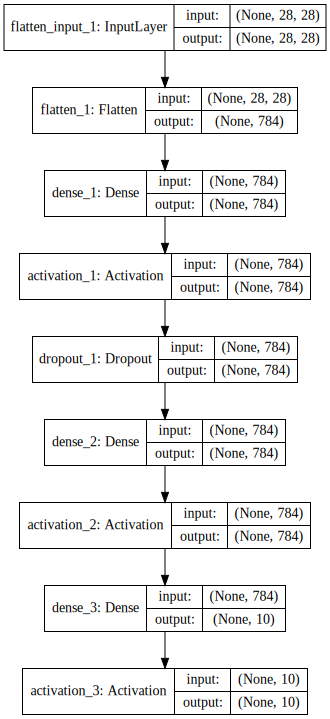

In [7]:
simple_ffn = Sequential()
simple_ffn.add(Flatten(input_shape=(resolution, resolution)))
#|
simple_ffn.add(Dense(resolution*resolution))
simple_ffn.add(Activation(activation="relu"))
#|
simple_ffn.add(Dropout(0.5)) #to prevent overfitting
#|
simple_ffn.add(Dense(resolution*resolution))
simple_ffn.add(Activation(activation="sigmoid")) #to limit the backpropagated gradient
#|
simple_ffn.add(Dense(classes))
simple_ffn.add(Activation(activation="softmax"))

VisualizeModel(simple_ffn)

Train on 14979 samples, validate on 3745 samples
Epoch 1/10
14979/14979 [==============================] - 2s - loss: 0.5384 - acc: 0.8407 - val_loss: 0.3750 - val_acc: 0.8961   96/14979 [..............................] - ETA: 2s - loss: 2.2308 - acc: 0.2292

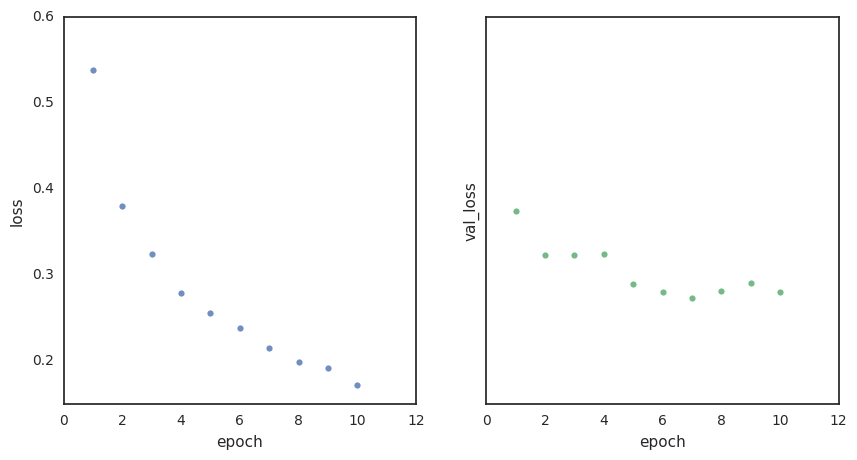

3648/3745 [============================>.] - ETA: 0s 384/3745 [==>...........................] - ETA: 0s




This mo

In [8]:
TrainAndAnalyze(simple_ffn, (X_train, Y_train), (X_test, Y_test), False, 'simple_feed_forward.h5')

#### This simple model obtained 91.80% accuracy, let's now increse the depth of this simple ANN

      OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

          Input   #####   (28, 28)
        Flatten   ||||| -------------------         0     0.0%
                  #####   (784,)
          Dense   XXXXX -------------------    615440    24.9%
           relu   #####   (784,)
        Dropout    | || -------------------         0     0.0%
                  #####   (784,)
          Dense   XXXXX -------------------    615440    24.9%
           relu   #####   (784,)
          Dense   XXXXX -------------------    615440    24.9%
           relu   #####   (784,)
        Dropout    | || -------------------         0     0.0%
                  #####   (784,)
          Dense   XXXXX -------------------    615440    24.9%
           relu   #####   (784,)
          Dense   XXXXX -------------------      7850     0.3%
        softmax   #####   (10,)


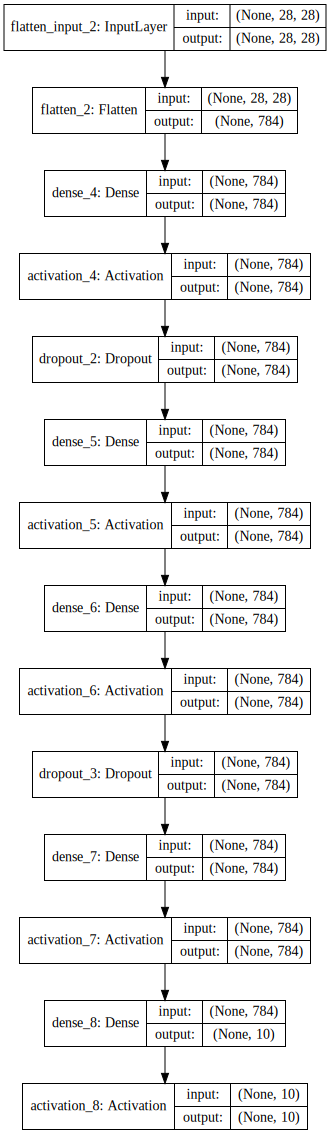

In [9]:
deeper_ffn = Sequential()
deeper_ffn.add(Flatten(input_shape=(resolution, resolution)))
#|
deeper_ffn.add(Dense(resolution*resolution))
deeper_ffn.add(Activation(activation="relu"))

deeper_ffn.add(Dropout(0.3)) #to prevent overfitting
#|
deeper_ffn.add(Dense(resolution*resolution))
deeper_ffn.add(Activation(activation="relu"))
#|
deeper_ffn.add(Dense(resolution*resolution))
deeper_ffn.add(Activation(activation="relu"))
#|
deeper_ffn.add(Dropout(0.5)) #to prevent overfitting
#|
deeper_ffn.add(Dense(resolution*resolution))
deeper_ffn.add(Activation(activation="relu"))
#|
deeper_ffn.add(Dense(classes))
deeper_ffn.add(Activation(activation="softmax"))

VisualizeModel(deeper_ffn)

Train on 14979 samples, validate on 3745 samples
Epoch 1/10
14979/14979 [==============================] - 4s - loss: 0.5763 - acc: 0.8245 - val_loss: 0.3909 - val_acc: 0.8892   64/14979 [..............................] - ETA: 5s - loss: 2.5647 - acc: 0.1562

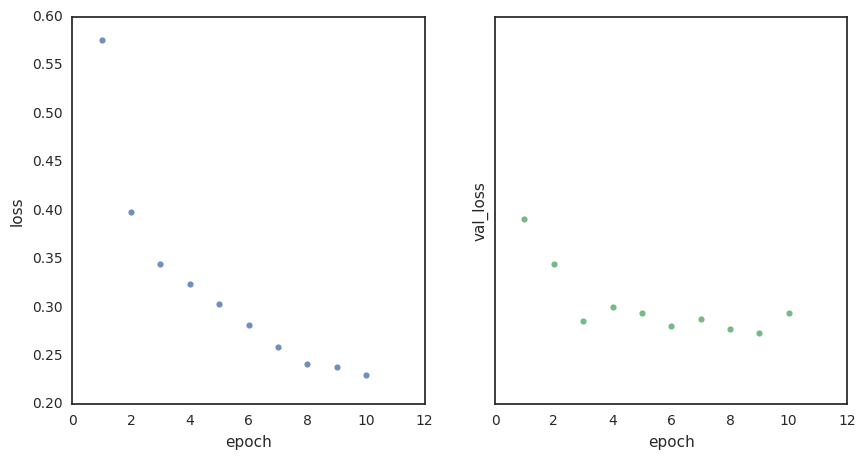

3745/3745 [==============================] - 0s      256/3745 [=>............................] - ETA: 0s

In [10]:
TrainAndAnalyze(deeper_ffn, (X_train, Y_train), (X_test, Y_test), False, 'deeper_feed_forward.h5')

### By increasing the depth of the ANN the accuracy droped to 91.75%
### By increasing the depth we significantly increased the number of degrees of freedom in the model and because we got a limited set of training data this network won't outperform the previous. To increase the accuracy let's look at Convolutional Neural Networks

      OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

          Input   #####   (1, 28, 28)
  Convolution2D    \|/  -------------------      1600     0.2%
           relu   #####   (32, 34, 34)
  Convolution2D    \|/  -------------------      9248     1.1%
           relu   #####   (32, 32, 32)
   MaxPooling2D   YYYYY -------------------         0     0.0%
                  #####   (32, 16, 16)
        Dropout    | || -------------------         0     0.0%
                  #####   (32, 16, 16)
        Flatten   ||||| -------------------         0     0.0%
                  #####   (8192,)
          Dense   XXXXX -------------------    819300    98.6%
           relu   #####   (100,)
        Dropout    | || -------------------         0     0.0%
                  #####   (100,)
          Dense   XXXXX -------------------      1010     0.1%
        softmax   #####   (10,)


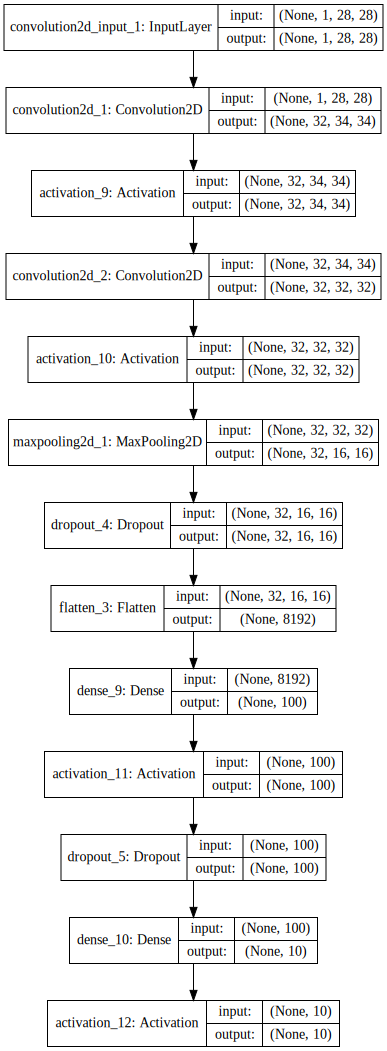

In [11]:
simple_conv = Sequential()
simple_conv.add(Convolution2D(32, 7, 7, border_mode='full', input_shape=(1, resolution, resolution)))
simple_conv.add(Activation('relu'))
#|
simple_conv.add(Convolution2D(32, 3, 3,))
simple_conv.add(Activation('relu'))
#|
simple_conv.add(MaxPooling2D(pool_size=(2,2)))
simple_conv.add(Dropout(0.25))
#|
simple_conv.add(Flatten())
simple_conv.add(Dense(classes*classes))
simple_conv.add(Activation('relu'))
simple_conv.add(Dropout(0.5))
simple_conv.add(Dense(classes))
simple_conv.add(Activation('softmax'))

VisualizeModel(simple_conv)

In [12]:
#Reshape the input for CNN
X_train = X_train.reshape(X_train.shape[0], 1, resolution, resolution)
X_test = X_test.reshape(X_test.shape[0], 1, resolution, resolution)

Train on 14979 samples, validate on 3745 samples
Epoch 1/10
14979/14979 [==============================] - 23s - loss: 0.5507 - acc: 0.8356 - val_loss: 0.2756 - val_acc: 0.9132   64/14979 [..............................] - ETA: 21s - loss: 2.2806 - acc: 0.1250

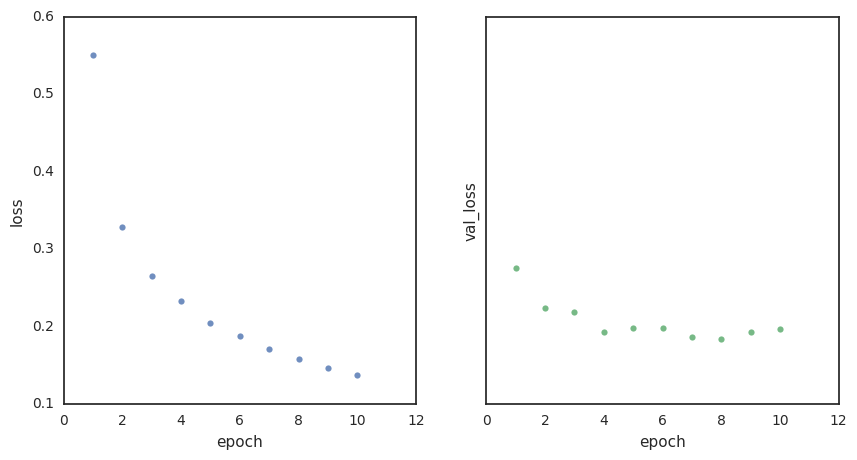

3744/3745 [============================>.] - ETA: 0s  64/3745 [..............................] - ETA: 2s

In [13]:
TrainAndAnalyze(simple_conv, (X_train, Y_train), (X_test, Y_test), False, 'simple_conv_net.h5')

### Using this CNN i got 94.02% accuracy
### Let's visualize the weights in the first conv layer to see what are they filtering

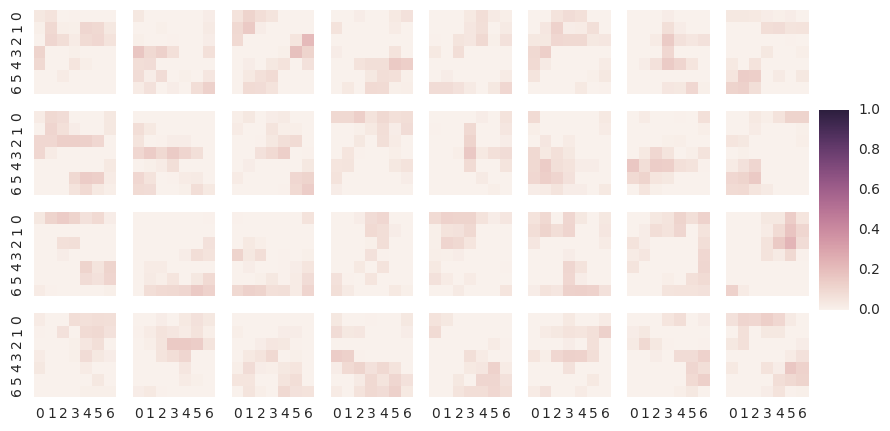

In [14]:
weights = simple_conv.layers[0].W.get_value(borrow=True)

plt.rcParams['figure.figsize'] = (10,5)
fig, axn = plt.subplots(4, 8, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
for i, ax in enumerate(axn.flat):
    sns.heatmap(weights[i][0], ax=ax,
                cbar=i == 0,
                vmin=0, vmax=1,
                cbar_ax=None if i else cbar_ax,
               xticklabels=True, yticklabels=True)
plt.show()


### By looking at the above image i think that most of the filters are trying to detect edges in a given image at a specific angle

### Let's apply these filters to a sample input to check my guess

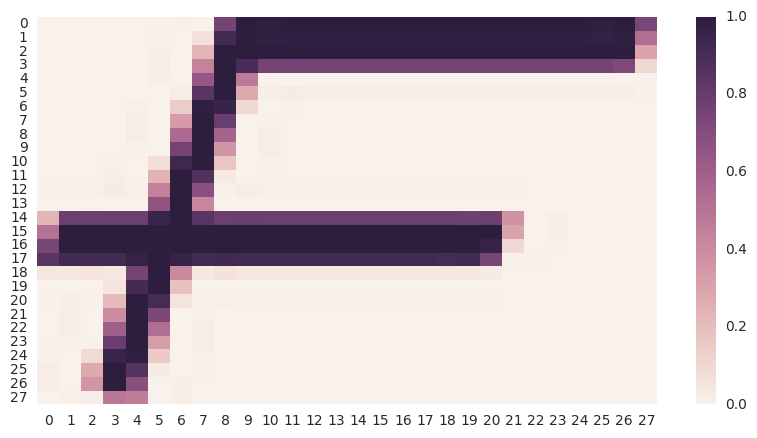

In [15]:
#first obtain and plot a sample image
np.random.seed(4*4)
sample_image = X_test[np.random.randint(0, X_test_len)]
sns.heatmap(sample_image[0])

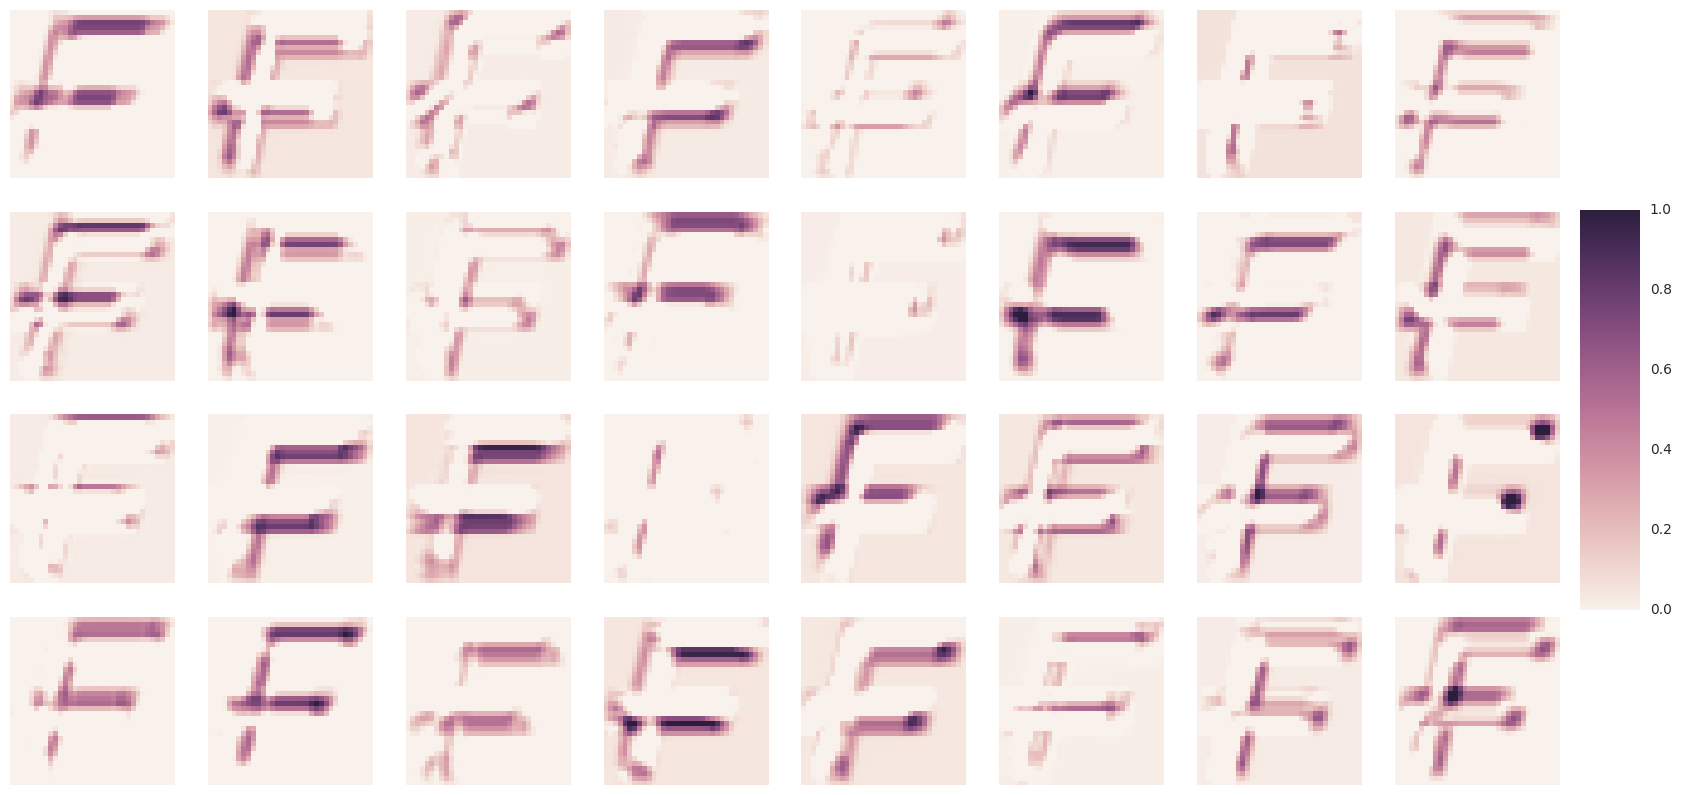

In [16]:
convout1_f = theano.function(simple_conv.inputs, [simple_conv.layers[1].output])
transformed_sample_images = np.array(convout1_f([sample_image]))[0][0]

plt.rcParams['figure.figsize'] = (20,10)
fig, axn = plt.subplots(4, 8, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
for i, ax in enumerate(axn.flat):
    sns.heatmap(transformed_sample_images[i], ax=ax,
                cbar=i == 0,
                vmin=0, vmax=1,
                cbar_ax=None if i else cbar_ax,
               xticklabels=False, yticklabels=False)
plt.show()


### As we can see the learned 7x7 filters try to recover the outline of the letter in a given direction
## Now let's see how accurate SqueezeNet will be (https://arxiv.org/pdf/1602.07360.pdf)

      OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

          Input   #####   (1, 28, 28)
     InputLayer   ????? -------------------         0     0.0%
                  #####   (1, 28, 28)
   UpSampling2D   ????? -------------------         0     0.0%
                  #####   (1, 224, 224)
  Convolution2D    \|/  -------------------      4800     0.7%
           relu   #####   (96, 112, 112)
   MaxPooling2D   YYYYY -------------------         0     0.0%
                  #####   (96, 55, 55)
  Convolution2D    \|/  -------------------      1552     0.2%
           relu   #####   (16, 55, 55)
  Convolution2D    \|/  -------------------      1088     0.1%
           relu   #####   (64, 55, 55)
  Convolution2D    \|/  -------------------      9280     1.3%
           relu   #####   (64, 55, 55)
          Merge   ????? -------------------         0     0.0%
                  #####   (128, 55, 55)
  Convolution2D    \|/  -------------------      2064     0.3%
           

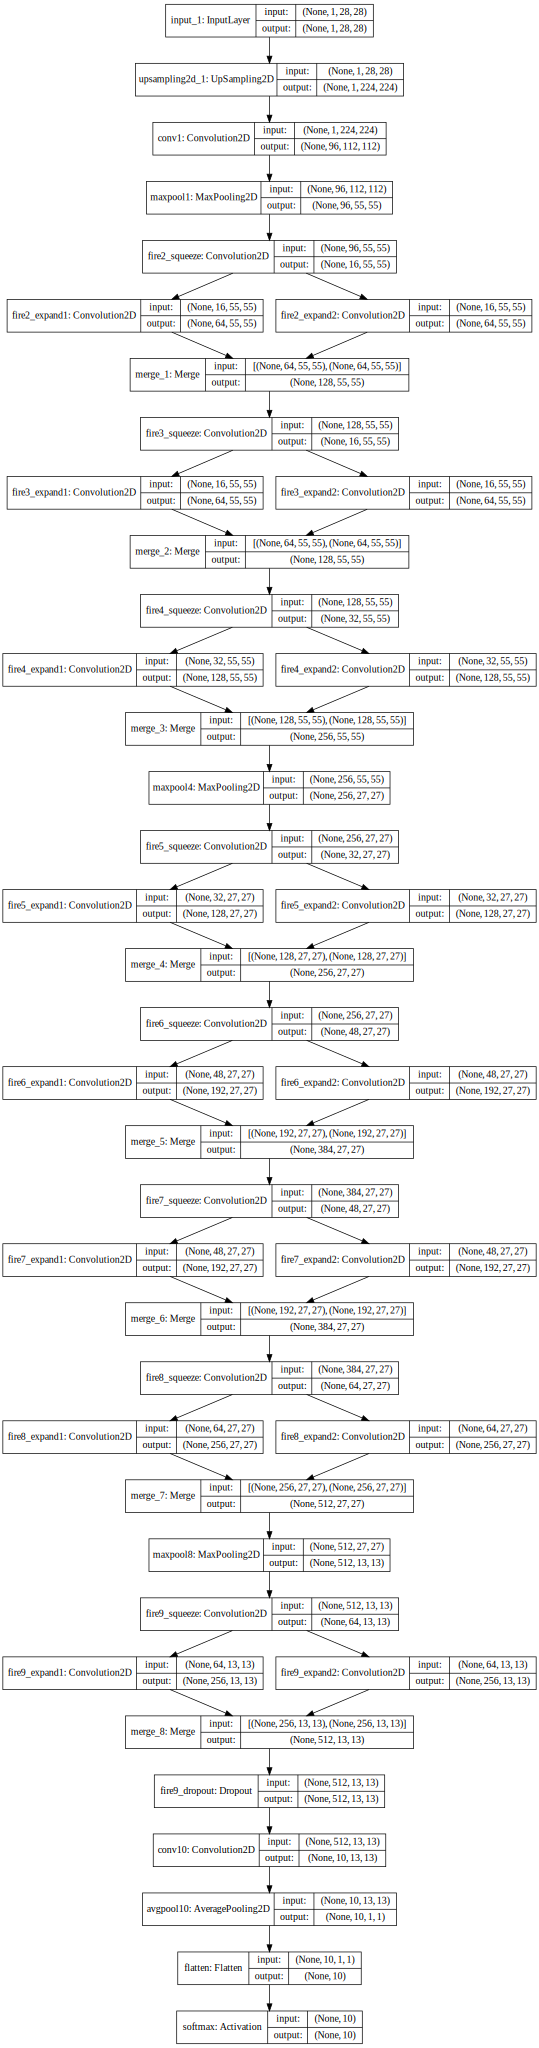

In [17]:
#Test whether UpSampling2D will work as intended
#test_l = UpSampling2D(dim_ordering='th', size=(8,8))
#test_l.build(input_shape=(1,28,28))
#sns.heatmap(np.array(test_l(theano.shared(X_test[0].reshape(1,1,28,28))).eval())[0][0])

#Based of https://github.com/DT42/squeezenet_demo
#I verified that the bellow code agrees with arXiv 1602.07360
#I added a layer to scale up the input image by a factor of 8 
def SqueezeNet(nb_classes, inputs):
    # Keras Implementation of SqueezeNet(arXiv 1602.07360)

    input_img = Input(shape=inputs)
    
    scaler1 = UpSampling2D(dim_ordering='th', size=(8,8))(input_img) #rescale the image by a factor of 8
    
    conv1 = Convolution2D(
        96, 7, 7, activation='relu', init='glorot_uniform', 
        subsample=(2, 2), border_mode='same', name='conv1')(scaler1)
    maxpool1 = MaxPooling2D(
        pool_size=(3, 3), strides=(2, 2), name='maxpool1')(conv1)

    fire2_squeeze = Convolution2D(
        16, 1, 1, activation='relu', init='glorot_uniform',
        border_mode='same', name='fire2_squeeze')(maxpool1)
    fire2_expand1 = Convolution2D(
        64, 1, 1, activation='relu', init='glorot_uniform',
        border_mode='same', name='fire2_expand1')(fire2_squeeze)
    fire2_expand2 = Convolution2D(
        64, 3, 3, activation='relu', init='glorot_uniform',
        border_mode='same', name='fire2_expand2')(fire2_squeeze)
    merge2 = merge(
        [fire2_expand1, fire2_expand2], mode='concat', concat_axis=1)

    fire3_squeeze = Convolution2D(
        16, 1, 1, activation='relu', init='glorot_uniform',
        border_mode='same', name='fire3_squeeze')(merge2)
    fire3_expand1 = Convolution2D(
        64, 1, 1, activation='relu', init='glorot_uniform',
        border_mode='same', name='fire3_expand1')(fire3_squeeze)
    fire3_expand2 = Convolution2D(
        64, 3, 3, activation='relu', init='glorot_uniform',
        border_mode='same', name='fire3_expand2')(fire3_squeeze)
    merge3 = merge(
        [fire3_expand1, fire3_expand2], mode='concat', concat_axis=1)

    fire4_squeeze = Convolution2D(
        32, 1, 1, activation='relu', init='glorot_uniform',
        border_mode='same', name='fire4_squeeze')(merge3)
    fire4_expand1 = Convolution2D(
        128, 1, 1, activation='relu', init='glorot_uniform',
        border_mode='same', name='fire4_expand1')(fire4_squeeze)
    fire4_expand2 = Convolution2D(
        128, 3, 3, activation='relu', init='glorot_uniform',
        border_mode='same', name='fire4_expand2')(fire4_squeeze)
    merge4 = merge(
        [fire4_expand1, fire4_expand2], mode='concat', concat_axis=1)
    maxpool4 = MaxPooling2D(
        pool_size=(3, 3), strides=(2, 2), name='maxpool4')(merge4)

    fire5_squeeze = Convolution2D(
        32, 1, 1, activation='relu', init='glorot_uniform',
        border_mode='same', name='fire5_squeeze')(maxpool4)
    fire5_expand1 = Convolution2D(
        128, 1, 1, activation='relu', init='glorot_uniform',
        border_mode='same', name='fire5_expand1')(fire5_squeeze)
    fire5_expand2 = Convolution2D(
        128, 3, 3, activation='relu', init='glorot_uniform',
        border_mode='same', name='fire5_expand2')(fire5_squeeze)
    merge5 = merge(
        [fire5_expand1, fire5_expand2], mode='concat', concat_axis=1)

    fire6_squeeze = Convolution2D(
        48, 1, 1, activation='relu', init='glorot_uniform',
        border_mode='same', name='fire6_squeeze')(merge5)
    fire6_expand1 = Convolution2D(
        192, 1, 1, activation='relu', init='glorot_uniform',
        border_mode='same', name='fire6_expand1')(fire6_squeeze)
    fire6_expand2 = Convolution2D(
        192, 3, 3, activation='relu', init='glorot_uniform',
        border_mode='same', name='fire6_expand2')(fire6_squeeze)
    merge6 = merge(
        [fire6_expand1, fire6_expand2], mode='concat', concat_axis=1)

    fire7_squeeze = Convolution2D(
        48, 1, 1, activation='relu', init='glorot_uniform',
        border_mode='same', name='fire7_squeeze')(merge6)
    fire7_expand1 = Convolution2D(
        192, 1, 1, activation='relu', init='glorot_uniform',
        border_mode='same', name='fire7_expand1')(fire7_squeeze)
    fire7_expand2 = Convolution2D(
        192, 3, 3, activation='relu', init='glorot_uniform',
        border_mode='same', name='fire7_expand2')(fire7_squeeze)
    merge7 = merge(
        [fire7_expand1, fire7_expand2], mode='concat', concat_axis=1)

    fire8_squeeze = Convolution2D(
        64, 1, 1, activation='relu', init='glorot_uniform',
        border_mode='same', name='fire8_squeeze')(merge7)
    fire8_expand1 = Convolution2D(
        256, 1, 1, activation='relu', init='glorot_uniform',
        border_mode='same', name='fire8_expand1')(fire8_squeeze)
    fire8_expand2 = Convolution2D(
        256, 3, 3, activation='relu', init='glorot_uniform',
        border_mode='same', name='fire8_expand2')(fire8_squeeze)
    merge8 = merge(
        [fire8_expand1, fire8_expand2], mode='concat', concat_axis=1)

    maxpool8 = MaxPooling2D(
        pool_size=(3, 3), strides=(2, 2), name='maxpool8')(merge8)

    fire9_squeeze = Convolution2D(
        64, 1, 1, activation='relu', init='glorot_uniform',
        border_mode='same', name='fire9_squeeze')(maxpool8)
    fire9_expand1 = Convolution2D(
        256, 1, 1, activation='relu', init='glorot_uniform',
        border_mode='same', name='fire9_expand1')(fire9_squeeze)
    fire9_expand2 = Convolution2D(
        256, 3, 3, activation='relu', init='glorot_uniform',
        border_mode='same', name='fire9_expand2')(fire9_squeeze)
    merge9 = merge(
        [fire9_expand1, fire9_expand2], mode='concat', concat_axis=1)

    fire9_dropout = Dropout(0.5, name='fire9_dropout')(merge9)
    conv10 = Convolution2D(
        nb_classes, 1, 1, init='glorot_uniform',
        border_mode='valid', name='conv10')(fire9_dropout)
    # The size should match the output of conv10
    avgpool10 = AveragePooling2D((13, 13), name='avgpool10')(conv10)

    flatten = Flatten(name='flatten')(avgpool10)
    softmax = Activation("softmax", name='softmax')(flatten)

    return Model(input=input_img, output=softmax)

squeezeNet = SqueezeNet(classes, (1,resolution,resolution))

VisualizeModel(squeezeNet)

## Now let's train SqueezeNet

In [ ]:
#this takes 3h to execute with default adam optimizer and all training data
TrainAndAnalyze(squeezeNet, (X_train, Y_train), (X_test, Y_test), False, 'squeeze_net.h5')

I have experimented with diffrent optimizers with diffrent configurations and none of them produced good accuracy over a reasonable amount of time. I've tried to reduce the size of the dataset and train for more epochs but this also failed. Lastly I have tried fine-tuning a pretrained squeezeNet network but after obtaining the pretrained weights from https://github.com/DeepScale/SqueezeNet/blob/master/SqueezeNet_v1.0/squeezenet_v1.0.caffemodel i was not able to convert them to the format used by Keras.

# Summary

The most accurate approach was a Convolutional Neural Network as shown before in this jupyter notebook. The obtained accuracy is approximately: 94% - this result doesn't change on diffrent runs on my CPU but when I used the GPU for calculations i could obtain 95% accuracy depending on the provided theano options - I think this is caused by race conditions caused when rand is called on the GPU - becouse of this i'm attaching my theanorc file. I have shown what is the job of the first convolutional layer in that network and demonstrated it on an example. I think SqueezeNet would obtain a good result but it requires time and resources to train such a big network. The statistics for what letters are mistaken for and how often it happens were calculated in this jupyter notebook. For my network i obtained that:

"A" is most often mistaken for "H" and that happened in 1.88% of predictions for "A"

"B" is most often mistaken for "E" and that happened in 1.07% of predictions for "B"

"C" is most often mistaken for "G" and that happened in 1.09% of predictions for "C"

"D" is most often mistaken for "B" and that happened in 1.81% of predictions for "D"

"E" is most often mistaken for "C" and that happened in 2.93% of predictions for "E"

"F" is most often mistaken for "G" and that happened in 1.56% of predictions for "F"

"G" is most often mistaken for "C" and that happened in 4.31% of predictions for "G"

"H" is most often mistaken for "A" and that happened in 2.68% of predictions for "H"

"I" is most often mistaken for "J" and that happened in 1.59% of predictions for "I"

"J" is most often mistaken for "I" and that happened in 5.71% of predictions for "J"
